In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Ignorer les warnings de type FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# 1. Paramètres modifiables
initial_portfolio_value = 100000  # Portefeuille initial en dollars
allocation_etf = 2/3  # 66% dans les ETF
allocation_trading = 1/3  # 33% dans le trading opportuniste
stop_loss_threshold = 0.01  # Stop-loss à 1%
trailing_stop_threshold = 0.01  # Trailing stop à 1%
etf_tickers = ['VOO', 'QQQ']  # ETF principaux
start_year = 2019
end_year = 2024

# Liste des actions à considérer pour le trading opportuniste
tickers = etf_tickers + ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX', 'MSFT', 'NVDA', 'TSLA']

# Télécharger les données pour toutes les années
data = yf.download(tickers, start=f'{start_year}-01-01', end=f'{end_year}-12-31')

# Calcul des rendements quotidiens
adj_close = data['Adj Close']
returns = adj_close.pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [33]:
# Placeholder pour la valeur du portefeuille sur chaque année
portfolio_values = {}

for year in range(start_year, end_year + 1):
    # Filtrer les données pour l'année en cours
    year_data = data.loc[f'{year}-01-01':f'{year}-12-31']
    year_returns = returns.loc[f'{year}-01-01':f'{year}-12-31']
    
    # Initialiser le portefeuille
    portfolio_value = initial_portfolio_value
    etf_allocation_value = portfolio_value * allocation_etf
    trading_allocation_value = portfolio_value * allocation_trading
    etf_weights = np.array([0.46, 0.20]) / (0.46 + 0.2)  # Pondération pour VOO et QQQ respectivement
    etf_positions = etf_allocation_value * etf_weights / year_data['Adj Close'].iloc[0][etf_tickers]
    
    # Tracker la valeur du portefeuille au fil du temps
    portfolio_daily_values = [portfolio_value]
    
    for date, daily_return in year_returns.iterrows():
        
        # Vérification au deuxième jour (première mise à jour)
        if date == year_returns.index[1]:  # Vérifie la deuxième journée
            print(f"\n--- Vérification au {date} ---")
            print(f"Prix des ETF au {date} :\n{year_data['Adj Close'].loc[date][etf_tickers]}")
            print(f"Valeur des positions ETF au {date} : {etf_daily_value}")
            print(f"Valeur totale du portefeuille au {date} : {portfolio_value}")
            
        # Mettre à jour la valeur des ETF
        etf_daily_value = (etf_positions * year_data['Adj Close'].loc[date][etf_tickers]).sum()
        
        # Sélectionner les actions pour le trading opportuniste
        candidate_stocks = year_returns.loc[date][(year_returns.loc[date] <= -0.02)].index
        
        # Mettre à jour la valeur totale du portefeuille
        portfolio_value = etf_daily_value + trading_allocation_value
        portfolio_daily_values.append(portfolio_value)
    
    # Enregistrer la valeur du portefeuille pour l'année
    portfolio_values[year] = portfolio_daily_values


--- Vérification au 2019-01-04 00:00:00 ---
Prix des ETF au 2019-01-04 00:00:00 :
VOO    210.247955
QQQ    150.277878
Name: 2019-01-04 00:00:00, dtype: float64
Valeur des positions ETF au 2019-01-04 00:00:00 : 64897.515193456115
Valeur totale du portefeuille au 2019-01-04 00:00:00 : 98230.84852678944

--- Vérification au 2020-01-03 00:00:00 ---
Prix des ETF au 2020-01-03 00:00:00 :
VOO    274.098389
QQQ    207.717758
Name: 2020-01-03 00:00:00, dtype: float64
Valeur des positions ETF au 2020-01-03 00:00:00 : 66666.66666666666
Valeur totale du portefeuille au 2020-01-03 00:00:00 : 99999.99999999999

--- Vérification au 2021-01-05 00:00:00 ---
Prix des ETF au 2021-01-05 00:00:00 :
VOO    321.553833
QQQ    304.172577
Name: 2021-01-05 00:00:00, dtype: float64
Valeur des positions ETF au 2021-01-05 00:00:00 : 66666.66666666666
Valeur totale du portefeuille au 2021-01-05 00:00:00 : 99999.99999999999

--- Vérification au 2022-01-04 00:00:00 ---
Prix des ETF au 2022-01-04 00:00:00 :
VOO    419

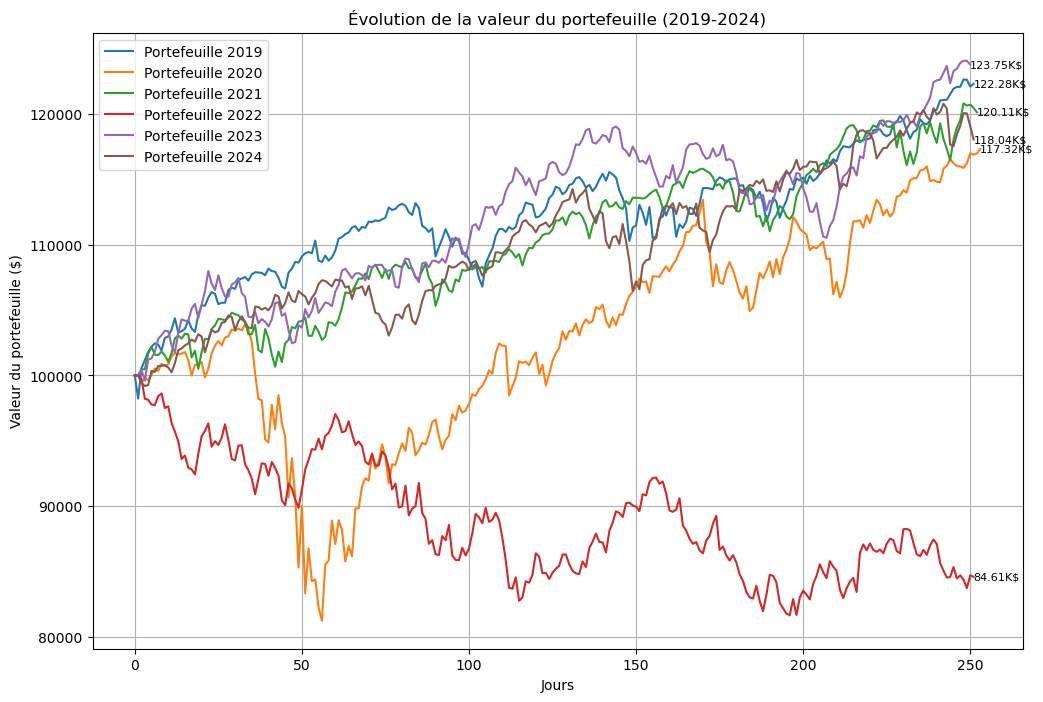

In [34]:
# Visualisation des résultats avec data labels formatés en milliers
plt.figure(figsize=(12, 8))

for year, values in portfolio_values.items():
    plt.plot(values, label=f'Portefeuille {year}')
    
    # Ajouter un data label pour la valeur finale formatée en milliers
    final_value = values[-1]  # Dernière valeur de l'année
    final_value_k = final_value / 1000  # Conversion en milliers
    plt.text(len(values) - 1, final_value, f'{final_value_k:.2f}K$', 
             ha='left', va='center', fontsize=8, color='black')

plt.title('Évolution de la valeur du portefeuille (2019-2024)')
plt.xlabel('Jours')
plt.ylabel('Valeur du portefeuille ($)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Initialiser le portefeuille
portfolio_value = initial_portfolio_value
etf_allocation_value = portfolio_value * allocation_etf
trading_allocation_value = portfolio_value * allocation_trading
etf_weights = np.array([0.46, 0.20])  # Pondération pour VOO et QQQ respectivement

# Vérification : afficher les prix initiaux des ETF
print("Prix initiaux des ETF (VOO et QQQ) :")
print(year_data['Adj Close'].iloc[0][etf_tickers])

etf_positions = etf_allocation_value * etf_weights / year_data['Adj Close'].iloc[0][etf_tickers]

# Vérification : afficher la valeur investie et les positions initiales
print(f"Valeur initiale investie dans les ETF : {etf_allocation_value}")
print(f"Positions initiales en ETF :\n{etf_positions}")

# Vérification : afficher la valeur totale du portefeuille au premier jour
print(f"Valeur totale du portefeuille au premier jour : {portfolio_value}")

Prix initiaux des ETF (VOO et QQQ) :
VOO    428.376892
QQQ    400.211700
Name: 2024-01-02 00:00:00, dtype: float64
Valeur initiale investie dans les ETF : 66666.66666666666
Positions initiales en ETF :
VOO    71.588051
QQQ    33.315701
Name: 2024-01-02 00:00:00, dtype: float64
Valeur totale du portefeuille au premier jour : 100000
